<a href="https://colab.research.google.com/github/gizdatalab/SDG_11_Tracking_Colombia/blob/main/Tracking_SDG_11_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook shows how to calculate Indicator 11.2.1: Proportion of population that has convenient access to public transport, by sex, age and persons with disabilities 
### Target 11.2: By 2030, provide access to safe, affordable, accessible and sustainable transport systems for all, improving road safety, notably by expanding public transport, with special attention to the needs of those in vulnerable situations, women, children, persons with disabilities and older persons

The data on public transportation is not yet sufficient!

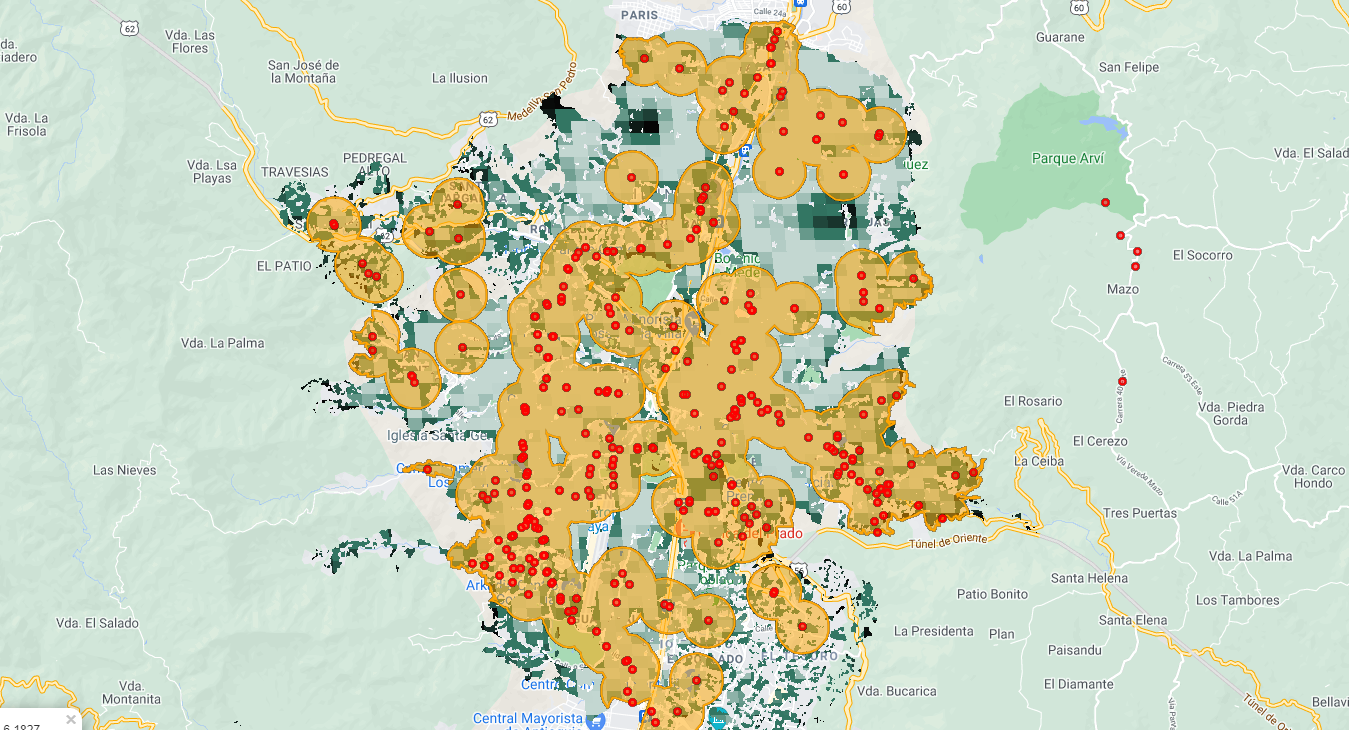

In [1]:
#@title Install packages { display-mode: "form" }
%%capture
# !pip install geopandas
# !pip install folium
!pip install geemap

In [2]:
# Import libraries
import geemap
import ee
from pprint import pprint 
# Trigger the authentication flow.
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=nm5FSeyYw9mP97LpPUfKkmrjqJ_KWkvAxd7XKHwAqxk&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWiBJ9uYu2qYxH2-FY7IlfqxZyHI_Ing4LL-W5mq0EH8RUT9a5K3li0

Successfully saved authorization token.


In [ ]:
# # mount to your google drive
# from google.colab import drive
# # drive.mount('/content/gdrive/', force_remount=True)

### Datasets

#### Determine AOI

In [7]:
# adminArea = ee.FeatureCollection("FAO/GAUL/2015/level2")\
#             .filter(ee.Filter.And(ee.Filter.eq("ADM0_NAME", 'Colombia'), ee.Filter.eq("ADM2_NAME", 'Medellin')))\
#             .first()

urban_bounds = ee.FeatureCollection("users/eriklehmann91/MGN_URB_AREA_CENSAL")\
                    .filterMetadata('NOM_CPOB', 'equals', 'MEDELLÍN') 

aoi = urban_bounds

#### Load built-up area




In [4]:
builtup = ee.Image('users/eriklehmann91/medellin_buildup_2021')

builtup = builtup.gte(0.75) # create mask of (non)-built-up areas


#### Load population datasets

In [5]:
# World population 100m 2020
WorldPop = ee.ImageCollection("WorldPop/GP/100m/pop_age_sex")\
                    .select('population')\
                    .filterMetadata('country', 'equals', 'COL')\
                    .first()\
                    .clip(aoi)\
                    .updateMask(builtup)
# JRC
JRC_pop = ee.ImageCollection('JRC/GHSL/P2016/POP_GPW_GLOBE_V1').filterBounds(aoi)\
                  .filter(ee.Filter.date('2015-01-01', '2015-12-31'))\
                  .select(['population_count'], ['population'])\
                  .first()\
                  .clip(aoi)\
                  .updateMask(builtup)

#### Load data on public transport
These can be extracted from Open Street Map.

In [6]:
aerial = ee.FeatureCollection("users/estherbarvels/SDG_tracking_columbia/medellin_aerial_points")
bus = ee.FeatureCollection("users/estherbarvels/SDG_tracking_columbia/medellin_amenity_bus_points")
bus2 = ee.FeatureCollection("users/estherbarvels/SDG_tracking_columbia/medellin_highway_bus_points")
pubTrans = ee.FeatureCollection("users/estherbarvels/SDG_tracking_columbia/medellin_pubTrans_points")
bus_poly = ee.FeatureCollection("users/estherbarvels/SDG_tracking_columbia/medellin_amenity_bus_poly")

bus_centroids = bus_poly.map(lambda x: x.geometry().centroid(10)) # convert polygons to points (centroids)

stops_excl_aerial = bus.merge(bus2).merge(pubTrans).merge(bus_centroids) # includes all stops except cable cars (aerial)
stops = stops_excl_aerial.merge(aerial) # includes all stops

### Create buffer 
Create buffer around the public transport stations (points) to determine the area of the city where public transport is available.
1. Determine buffer distance in meter
2. Create buffer
3. Intersect buffer with Medellin's administrational area as we focus on the area within the city's boundaries.

In [8]:
bufferDist = 500 # buffer radius in meter

def bufferFeat(feature): return feature.buffer(bufferDist).set('FID', 1)

In [9]:
stops_buffer = stops.map(bufferFeat).geometry().dissolve()
stops_buffer_aoi = stops_buffer.intersection(aoi.geometry(), 10) 


stops_buffer_excl_aerial = stops_excl_aerial.map(bufferFeat).geometry().dissolve()
stops_buffer_excl_aerial_aoi = stops_buffer_excl_aerial.intersection(aoi.geometry(), 10)


#### Visualise

In [10]:
JRCpopulationCountVis = {
  'min': 0.0,
  'max': 1800.0,
  'palette': ['060606', '337663', '337663', 'ffffff'],
};
WorldPopVis = {
  'bands': ['population'],
  'min': 150,
  'max': 180,
  'palette': ['24126c', '1fff4f', 'd4ff50']
};

builtup_masked = builtup.updateMask(builtup.gte(0.75)) # mask non built-up

Map = geemap.Map()
Map.centerObject(aoi, 12)

Map.addLayer(builtup_masked, {'palette': 'pink'}, "Built-up area Medellin (pink)", False);
Map.addLayer(JRC_pop, JRCpopulationCountVis, 'JRC Population Count',False);
Map.addLayer(WorldPop, WorldPopVis, "WorldPop Population", False);

Map.addLayer(stops_buffer_aoi, {'color': 'orange'}, '500m-Buffer Public Transport (orange)');
Map.addLayer(stops_buffer_excl_aerial_aoi, {'color': 'blue'}, '500m-Buffer Public Transport exluding cableway (blue)',False);

# Map.addLayer(stops_buffer, {'color': 'pink'}, '500m-Buffer Public Transport');
# Map.addLayer(stops_buffer_excl_aerial, {'color': 'blue'}, '500m-Buffer Public Transport exluding cableway',False);

Map.addLayer(stops, {'color': 'red'}, 'Public Transport Stations', False);

Map.addLayer(aoi, {}, 'Urban area of Medellin (DANE)')
Map

### Select population dataset

In [13]:
# pop = WorldPop # WorldPop Global Project Population Data

pop = JRC_pop # Global Human Settlement Layers by JRC

### How much of the population has access to public transport?

In [12]:
# compute total number of population
pop_total = pop.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = aoi.geometry(),
  scale = 100,
  maxPixels = 1e9
).get('population');

# compute the number of population that has access to public transport
pop_access = pop.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = stops_buffer_aoi,
  scale = 100,
  maxPixels = 1e9
).get('population');

# compute the number of population that has access to public transport without cable cars
pop_access_excl_aerial = pop.reduceRegion(
  reducer = ee.Reducer.sum(),
  geometry = stops_buffer_excl_aerial_aoi,
  scale = 100,
  maxPixels = 1e9
).get('population');


# compute the proportion of population that has access to public transport  

print('Total population: ', pop_total.getInfo())  
print('Population with access to public transport: ', pop_access.getInfo()) 
print('Population with access to public transport without cable cars: ', pop_access_excl_aerial.getInfo())

perc_accessPubTrans = ee.Number(pop_access).divide(ee.Number(pop_total))
perc_accessPubTrans_excl_aerial = ee.Number(pop_access_excl_aerial).divide(ee.Number(pop_total))
print('Proportion of population with access to public transport (%): ', round(perc_accessPubTrans.getInfo(),2))
print('Proportion of population with access to public transport without cable cars (%): ', round(perc_accessPubTrans_excl_aerial.getInfo(),2))


Total population:  9835002.833569495
Population with access to public transport:  6430000.784147885
Population with access to public transport without cable cars:  5706554.364134154
Proportion of population with access to public transport (%):  0.65
Proportion of population with access to public transport without cable cars (%):  0.58


## How much of the population resides on steep slopes?
Note that with this method only areas within the urban boundaries are considered. This means that informal settlements (which tend to be built on steep hillsides) outside the boundaries are not included and the results may be underestimated.

In [14]:
import math

# Define a function to convert from degrees to radians.
def radians(img):
  return img.toFloat().multiply(math.pi).divide(180);


In [15]:
# Compute terrain meaasures from the SRTM DEM.
terrain = ee.Algorithms.Terrain(ee.Image('CGIAR/SRTM90_V4').clip(aoi));
slope = radians(terrain.select('slope'));

Define the slope threholds (in radians) that are used to classify the slopes. What is considered an **"extremely steep"** slope, is significant for determining the proportion of the population that resides on steep slopes later on in this analysis.

In [16]:
extremly_steep = 0.36 
moderately_steep = 0.16

In [17]:
# Reclassify slope values.
slope_reclass = ee.Image(0)\
                .where(slope.lt(moderately_steep), 0)\
                .where(slope.gt(moderately_steep).And(slope.lt(extremly_steep)), 1)\
                .where(slope.gte(extremly_steep), 2)\
                .clip(aoi)

In [18]:
Map = geemap.Map()
Map.centerObject(aoi, 12)
Map.addLayer(slope, {}, 'Slope');
Map.addLayer(slope_reclass, {'palette':['white', 'blue', 'red']}, 'Slope reclassified (blue: moderately steep; red: extremely steep)');  

Map

### Compute proportion per slope class

In [19]:
stats = ee.List(pop.addBands(slope_reclass).reduceRegion(
  reducer = ee.Reducer.sum().group(
    groupField = 1,
    groupName = 'constant',
  ),
  geometry = aoi,
  scale = 100,
  maxPixels = 1e8
).get('groups'));

# print(stats.getInfo())


values = stats.map(lambda x: ee.Number(ee.Dictionary(x).get('sum')).divide(pop_total))
# print(values.getInfo())
print(round(values.get(2).getInfo(),2), '% of the population resides on steep slopes (slopes>=0.36 °)')

0.03 % of the population resides on steep slopes (slopes>=0.36 °)
